In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize
import scipy.ndimage

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\stPR_stLFP_Analysis.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 30*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

def bw_hp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "hp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

SAVE_PROGRESS(HISTORY_FILEPATH)  

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\stPR_stLFP_Analysis_2024-06-04.py


In [4]:
def population_coupling(src_spike_events, f_i_norms = None):
    nof_rois = src_spike_events.shape[0]

    roi_idxs = np.arange(nof_rois)
    c_is = np.zeros(src_spike_events.shape[:-1])
    for i_roi in roi_idxs:
        f_i = src_spike_events[[i_roi],...]
        if f_i_norms is None:
            f_i_norm = np.sum(f_i, axis = -1)
        else:
            f_i_norm = f_i_norms[i_roi,...]
        f_js = src_spike_events[roi_idxs != i_roi, ...]
        mu_js = np.mean(f_js, axis = -1, keepdims = True)
        c_i = (1/f_i_norm) * np.sum(f_i * (f_js - mu_js), axis = (0, -1))
        c_is[i_roi,...] = c_i

    return c_is

SAVE_PROGRESS(HISTORY_FILEPATH)   

Time since last sync = 12.05 s


In [27]:
def calculate_sta_vals(src_spike_events, src_vals, spike_win_lens):
    assert len(src_spike_events.shape) == 3
    assert len(spike_win_lens) == 2

    nof_rois, nof_trials, trace_len = src_spike_events.shape
    sta_vals = np.zeros((nof_rois, nof_trials, np.sum(spike_win_lens)))

    for i_trial in range(nof_trials):
        cur_trial_spike_event = src_spike_events[:,i_trial,:]
        cur_trial_vals = src_vals[:,i_trial,:]

        for i_roi in range(nof_rois):
            cur_spike_event = cur_trial_spike_event[i_roi,:]
            cur_vals = cur_trial_vals[i_roi,:]
            cur_sta_val = np.zeros((np.sum(spike_win_lens),))

            nof_spikes = 0
            for cur_spike_pos in np.where(cur_spike_event)[0]:
                cur_win_start = cur_spike_pos - spike_win_lens[0]
                cur_win_end = cur_spike_pos + spike_win_lens[1]
                if cur_win_start < 0 or cur_win_end >= trace_len:
                    continue
                cur_sta_val += cur_vals[cur_win_start:cur_win_end]
                nof_spikes += 1
            if nof_spikes > 0:
                cur_sta_val = cur_sta_val/nof_spikes
                sta_vals[i_roi, i_trial,:] = cur_sta_val
    return sta_vals

def calculate_roi_population_rate(src_spike_events):
    nof_rois = src_spike_events.shape[0]
    roi_prs = np.zeros(src_spike_events.shape)

    for i_roi in range(nof_rois):
        cur_spike_events = src_spike_events[i_roi,...]
        cur_pr = np.sum(src_spike_events, axis = 0) - cur_spike_events
        roi_prs[i_roi,...] = cur_pr

    return roi_prs
    
SAVE_PROGRESS(HISTORY_FILEPATH)    

Time since last sync = 83.95 s


In [143]:
def random_2x2box_shuffle(src_spike_event, nof_swap = 100, nof_poll = 100):
    assert len(src_spike_event.shape) == 2
    assert nof_swap >= 0
    assert nof_poll >= 0

    shuffle_spike_event = src_spike_event.copy()
    for i_swap in range(nof_swap):
        spike_row_idxs, spike_col_idxs = np.where(shuffle_spike_event)
        for i_poll in range(nof_poll):
            cur_poll_idxs = np.random.randint(low = 0, high = len(spike_row_idxs), size = (2,))
            cur_box_dia_rows = spike_row_idxs[cur_poll_idxs]
            cur_box_dia_cols = spike_col_idxs[cur_poll_idxs]
            if (not shuffle_spike_event[cur_box_dia_rows[0],cur_box_dia_cols[1]]) and (not shuffle_spike_event[cur_box_dia_rows[1],cur_box_dia_cols[0]]):

                shuffle_spike_event[cur_box_dia_rows[0],cur_box_dia_cols[1]] = True
                shuffle_spike_event[cur_box_dia_rows[1],cur_box_dia_cols[0]] = True
                shuffle_spike_event[cur_box_dia_rows[0],cur_box_dia_cols[0]] = False
                shuffle_spike_event[cur_box_dia_rows[1],cur_box_dia_cols[1]] = False

                break
    return shuffle_spike_event

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 565.70 s


In [180]:
src_hdf5_file_path = r"M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5"
src_lfp_file_path = r"M:\2023-05-11\M347\FOV02\Group01\lfp_estimation\data\lfp_traces.hdf5"

dst_dir_path = r"M:\2023-05-11\M347\FOV02\Group01\spike_triggered_event_analysis"
dst_data_subdir_name = r"data"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 1035.25 s


In [181]:

# src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"
# src_lfp_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\lfp_estimation\data\lfp_traces.hdf5"

# dst_dir_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\spike_triggered_event_analysis"
# dst_data_subdir_name = r"data"

# SAVE_PROGRESS(HISTORY_FILEPATH)

In [182]:
# load source data 

time_per_frame_ms = None 
ms_to_s = None
s_to_ms = None
fs = None

nof_rois = None
nof_trials = None
nof_frames = None
nof_orients = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:

    # print(hdf5_file.keys())

    time_per_frame_ms = hdf5_file["time_per_frame_ms"][()] 
    ms_to_s = hdf5_file["ms_to_s"][()]
    s_to_ms = hdf5_file["s_to_ms"][()]
    fs = hdf5_file["fs"][()]
        
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 1036.06 s


In [183]:
print(len(diff_t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

156
62
17
Time since last sync = 1036.07 s


In [184]:
lfp_dffs = None
with h5py.File(src_lfp_file_path, "r") as hdf5_file:
    lfp_dffs = hdf5_file["mean_dFFs"][()]
print(lfp_dffs.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

(156, 16, 3100)
Time since last sync = 1036.12 s


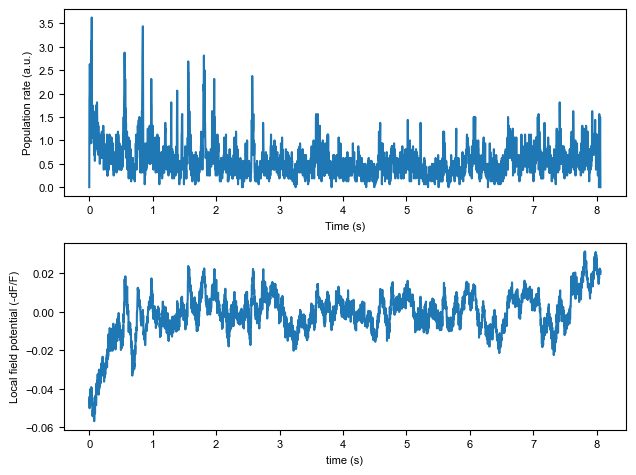

Time since last sync = 1036.45 s


In [185]:
tot_population_rates = np.mean(np.sum(roi_spike_events, axis = 0), axis = 0)
tot_lpf_dffs = np.mean(lfp_dffs, axis = (0,1))

plot_xs = np.arange(len(tot_population_rates)) * time_per_frame_ms * ms_to_s

plt.figure()
plt.subplot(2,1,1)
plt.plot(plot_xs, tot_population_rates)
plt.xlabel("Time (s)")
plt.ylabel("Population rate (a.u.)")
plt.subplot(2,1,2)
plt.plot(plot_xs, tot_lpf_dffs)
plt.xlabel("time (s)")
plt.ylabel("Local field potential (-dF/F)")
plt.tight_layout()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

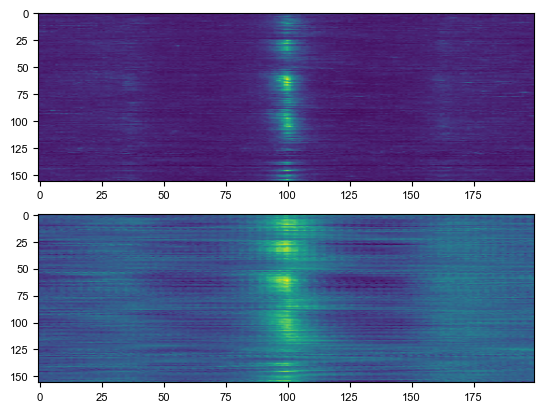

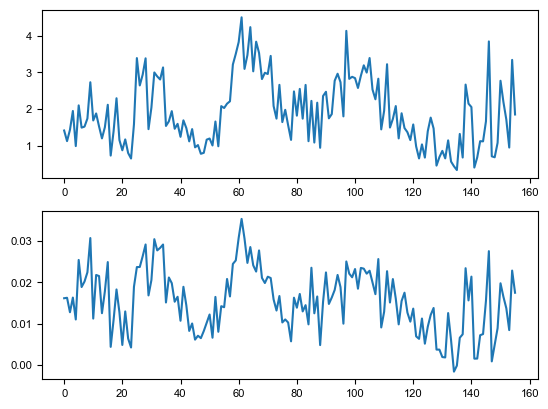

Time since last sync = 1038.15 s


In [186]:
spike_win_lens = np.array([100, 100])

roi_prs = calculate_roi_population_rate(roi_spike_events)
sta_prs = calculate_sta_vals(roi_spike_events, roi_prs, spike_win_lens)
sta_lfp_dffs = calculate_sta_vals(roi_spike_events, lfp_dffs, spike_win_lens)

trial_avg_sta_prs = np.mean(sta_prs, axis = 1)
trial_avg_sta_lfp_dffs = np.mean(sta_lfp_dffs, axis = 1)

gauss_hwhm = (12)/time_per_frame_ms
gauss_sigma = gauss_hwhm/np.sqrt(2*np.log(2))
trial_avg_sta_prs_lp = scipy.ndimage.gaussian_filter1d(trial_avg_sta_prs, gauss_sigma, axis = -1)

sta_pr_amps = trial_avg_sta_prs[:,spike_win_lens[0]]
sta_pr_lp_amps = trial_avg_sta_prs_lp[:,spike_win_lens[0]]
sta_lfp_amps = trial_avg_sta_lfp_dffs[:,spike_win_lens[0]]

plt.figure()
plt.subplot(2,1,1)
plt.imshow(trial_avg_sta_prs, aspect = "auto")
plt.subplot(2,1,2)
plt.imshow(trial_avg_sta_lfp_dffs, aspect = "auto")
plt.show()

plt.figure()
plt.subplot(2,1,1)
plt.plot(sta_pr_amps)
plt.subplot(2,1,2)
plt.plot(sta_lfp_amps)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [187]:
print(np.argsort(sta_pr_amps))
print(np.argsort(sta_lfp_amps))

[135 141 134 128 133  23 122 131 124 137 142 148 129 147  16  47  22  48
 130  20  88 153  45 121  53   4  51  46 123 149  86  43 144  84 143   1
 132 119  19  78  49  21  50  13 115  40 136 118  17 125   0   2 109  29
  44  38 127 117  42   6 112  14   7  12  35  77 120  24  39  75  52  36
 145  10  41 152 113  82  73   8  91 126  96  80 155  92  11 116  37   3
 110  76  55  30 140  54 114  72   5  15  56 139  87 151  57  85 107  18
  89  90  79 106  81 101  26  83  74 138   9  95 150  93  33  68  98 108
 100  99  32 102  27  70  94  69 104  31  65  62  34 103  58 111 154  28
  25 105  71  63  59  67  60  66 146  97  64  61]
[134 135 147 141 142 131 130 129 128  23  16  88  20 148 124  78 133  45
 122  22  47 136  51 121  46 143 137 144  53  48  43 153 149 109 125 115
  84  96  44  49  77  75 119  40  17   4  76  10 123 126  50  86  13 132
 118   2  19 110  21  82  73 120 152 127  80  55  54  42  83  91 112  35
  89  38 116 145 139  72 114   0   1  79   3  92  52 151  39  87  57  74
 

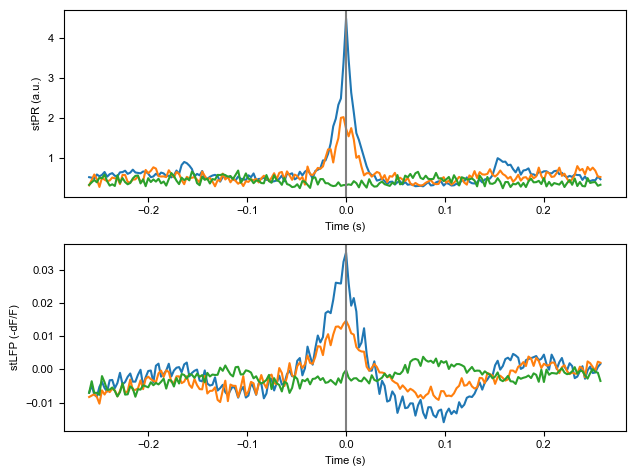

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\stPR_stLFP_Analysis_2024-06-05.py


In [190]:
plot_roi_idxs = [61, 91, 135] # M347
# plot_roi_idxs = [190, 48, 77] # M377


plot_sta_ptrs = trial_avg_sta_prs
# plot_sta_ptrs = trial_avg_sta_prs_lp
plot_sta_lfp_dffs = trial_avg_sta_lfp_dffs

plot_xs = np.arange(-spike_win_lens[0], spike_win_lens[0]) * time_per_frame_ms * ms_to_s

plt.figure()
plt.subplot(2,1,1)
for cur_roi_idx in plot_roi_idxs:
    plt.plot(plot_xs, plot_sta_ptrs[cur_roi_idx,:])
plt.axvline(0, color = "gray")
plt.ylabel("stPR (a.u.)")
plt.xlabel("Time (s)")
plt.subplot(2,1,2)
for cur_roi_idx in plot_roi_idxs:
    plt.plot(plot_xs, plot_sta_lfp_dffs[cur_roi_idx,:])
plt.axvline(0, color = "gray")
plt.ylabel("stLFP (-dF/F)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

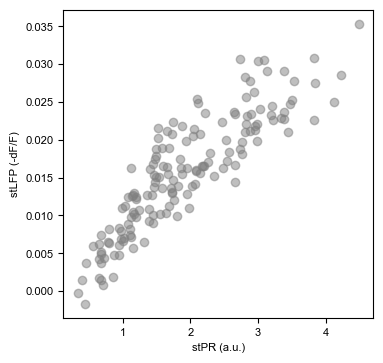

Time since last sync = 13.39 s


In [191]:
plot_xs = sta_pr_amps
plot_ys = sta_lfp_amps

plt.figure(figsize = (4,4))
plt.scatter(x = plot_xs, y = plot_ys, color = "gray", alpha = 0.5)
plt.xlabel("stPR (a.u.)")
plt.ylabel("stLFP (-dF/F)")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [192]:
f_i_norms = np.mean(roi_spike_events, axis = -1)
c_is = population_coupling(src_spike_events = roi_spike_events, f_i_norms = f_i_norms)

gauss_hwhm = (12/np.sqrt(2))/time_per_frame_ms
gauss_sigma = gauss_hwhm/np.sqrt(2*np.log(2))
roi_spike_events_lp = scipy.ndimage.gaussian_filter1d(roi_spike_events, gauss_sigma, axis = -1)
c_is_lp = population_coupling(src_spike_events = roi_spike_events_lp, f_i_norms = f_i_norms)

print(f_i_norms.shape)
print(c_is.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

C:\Users\zhong\AppData\Local\Temp\ipykernel_24708\3979108000.py:14: RuntimeWarning: divide by zero encountered in divide
  c_i = (1/f_i_norm) * np.sum(f_i * (f_js - mu_js), axis = (0, -1))
C:\Users\zhong\AppData\Local\Temp\ipykernel_24708\3979108000.py:14: RuntimeWarning: invalid value encountered in multiply
  c_i = (1/f_i_norm) * np.sum(f_i * (f_js - mu_js), axis = (0, -1))


(156, 16)
(156, 16)
Time since last sync = 42.30 s


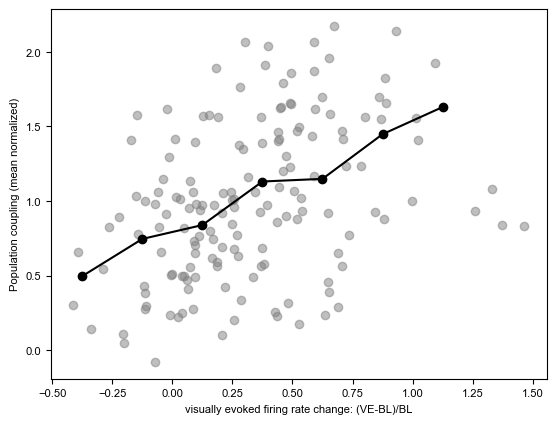

Time since last sync = 42.46 s


In [193]:
# pop_couplings = np.nanmean(c_is, axis = -1)
pop_couplings = np.nanmean(c_is_lp, axis = -1)
pop_couplings = pop_couplings/np.mean(pop_couplings)

fr_increase = np.mean(roi_spike_rates[:,:,1,:], axis = (-1,-2))/np.mean(roi_spike_rates[:,:,0,:], axis = (-1,-2))
fr_increase = fr_increase - 1

plot_xs = fr_increase
plot_ys = pop_couplings

bin_edges = np.arange(-0.5,1.5,0.25)
nof_bins = len(bin_edges) - 1
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_heights = np.zeros((nof_bins,))
for i_bin in range(nof_bins):
    cur_bin_mask = np.logical_and(plot_xs >= bin_edges[i_bin], plot_xs < bin_edges[i_bin+1])
    cur_bin_height = np.mean(plot_ys[cur_bin_mask])
    bin_heights[i_bin] = cur_bin_height

plt.figure()
plt.scatter(x = fr_increase, y = pop_couplings, color = "gray", alpha = 0.5)
plt.plot(bin_centers, bin_heights, '-ok')
plt.xlabel("visually evoked firing rate change: (VE-BL)/BL")
plt.ylabel("Population coupling (mean normalized)")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

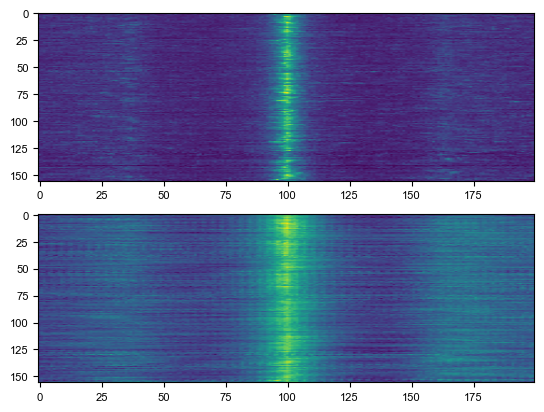

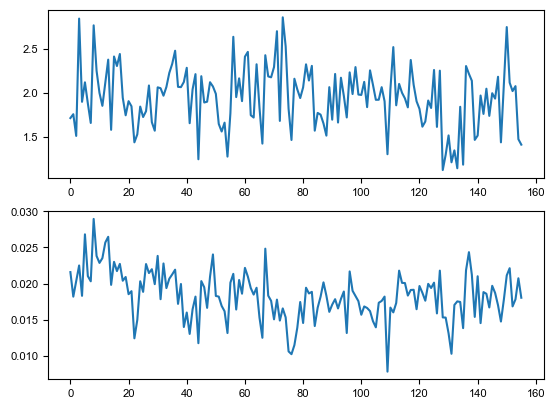

Time since last sync = 176.98 s


In [194]:
# shuffle test

random_generator = np.random.default_rng()

nof_rois = roi_spike_events.shape[0]
nof_trials = roi_spike_events.shape[1]
trace_len = roi_spike_events.shape[-1]

roi_idxs_shuffle = np.arange(nof_rois)
# random_generator.shuffle(roi_idxs_shuffle)

trace_idxs_shuffle = np.arange(trace_len)
# random_generator.shuffle(trace_idxs_shuffle)

roi_spike_events_shuffle = roi_spike_events.copy()
for i_trial in range(nof_trials):
    roi_spike_events_shuffle[:,i_trial,:] = random_2x2box_shuffle(
        roi_spike_events_shuffle[:,i_trial,:],
        nof_swap = 2500, 
        nof_poll = 100,
    )

assert np.any(roi_spike_events_shuffle != roi_spike_events)
assert np.all(np.sum(roi_spike_events_shuffle, axis = 0) == np.sum(roi_spike_events, axis = 0))
assert np.all(np.sum(roi_spike_events_shuffle, axis = -1) == np.sum(roi_spike_events, axis = -1))
        

# roi_spike_events_shuffle = roi_spike_events.copy()
# assert np.all(np.equal(np.sum(roi_spike_events_shuffle, axis = 0), np.sum(roi_spike_events_shuffle[roi_idxs_shuffle,...], axis = 0)))
# roi_spike_events_shuffle = roi_spike_events_shuffle[roi_idxs_shuffle,...]
# assert np.all(np.equal(np.sum(roi_spike_events_shuffle, axis = -1), np.sum(roi_spike_events_shuffle[...,trace_idxs_shuffle], axis = -1)))
# roi_spike_events_shuffle = roi_spike_events_shuffle[...,trace_idxs_shuffle]
# # random_generator.shuffle(roi_spike_events_shuffle, axis = -1)

lfp_dffs_shuffle = lfp_dffs[roi_idxs_shuffle,...]

roi_prs_shuffle = calculate_roi_population_rate(roi_spike_events_shuffle)
sta_prs_shuffle = calculate_sta_vals(roi_spike_events_shuffle, roi_prs_shuffle, spike_win_lens)
sta_lfp_dffs_shuffle = calculate_sta_vals(roi_spike_events_shuffle, lfp_dffs_shuffle, spike_win_lens)

trial_avg_sta_prs_shuffle = np.mean(sta_prs_shuffle, axis = 1)
trial_avg_sta_lfp_dffs_shuffle = np.mean(sta_lfp_dffs_shuffle, axis = 1)

gauss_hwhm = (12)/time_per_frame_ms
gauss_sigma = gauss_hwhm/np.sqrt(2*np.log(2))
trial_avg_sta_prs_shuffle_lp = scipy.ndimage.gaussian_filter1d(trial_avg_sta_prs_shuffle, gauss_sigma, axis = -1)

sta_pr_amps_shuffle = trial_avg_sta_prs_shuffle[:,spike_win_lens[0]]
sta_pr_lp_amps_shuffle = trial_avg_sta_prs_shuffle_lp[:,spike_win_lens[0]]
sta_lfp_amps_shuffle = trial_avg_sta_lfp_dffs_shuffle[:,spike_win_lens[0]]

plt.figure()
plt.subplot(2,1,1)
plt.imshow(trial_avg_sta_prs_shuffle, aspect = "auto")
plt.subplot(2,1,2)
plt.imshow(trial_avg_sta_lfp_dffs_shuffle, aspect = "auto")
plt.show()

plt.figure()
plt.subplot(2,1,1)
plt.plot(sta_pr_amps_shuffle)
plt.subplot(2,1,2)
plt.plot(sta_lfp_amps_shuffle)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

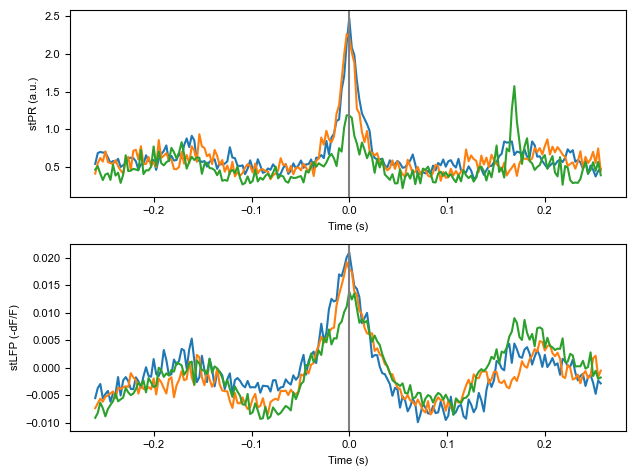

Time since last sync = 177.29 s


In [195]:
plot_roi_idxs = [61, 91, 135] # M347
# plot_roi_idxs = [190, 48, 77] # M377

plot_sta_roi_idxs = roi_idxs_shuffle

plot_sta_ptrs = trial_avg_sta_prs_shuffle
plot_sta_lfp_dffs = trial_avg_sta_lfp_dffs_shuffle

plot_xs = np.arange(-spike_win_lens[0], spike_win_lens[0]) * time_per_frame_ms * ms_to_s

plt.figure()
plt.subplot(2,1,1)
for cur_roi_idx in plot_roi_idxs:
    plt.plot(plot_xs, np.squeeze(plot_sta_ptrs[plot_sta_roi_idxs == cur_roi_idx,:]))
plt.axvline(0, color = "gray")
plt.ylabel("stPR (a.u.)")
plt.xlabel("Time (s)")
plt.subplot(2,1,2)
for cur_roi_idx in plot_roi_idxs:
    plt.plot(plot_xs, np.squeeze(plot_sta_lfp_dffs[plot_sta_roi_idxs == cur_roi_idx,:]))
plt.axvline(0, color = "gray")
plt.ylabel("stLFP (-dF/F)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [196]:
print(plot_sta_roi_idxs)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155]


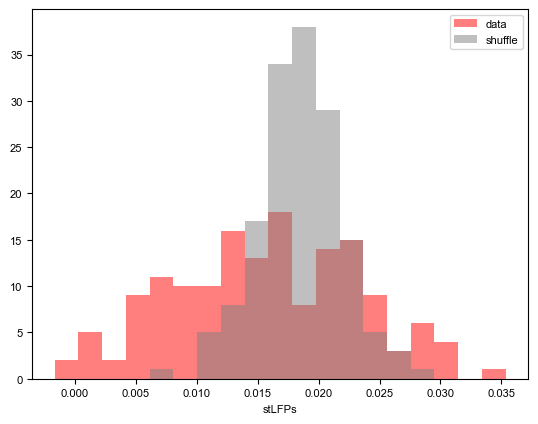

In [197]:
plot_vals = np.stack([sta_lfp_amps, sta_lfp_amps_shuffle], axis = 0)
plot_labels = ["data", "shuffle"]
plot_colors = ["red", "gray"]

plot_bin_edges = np.linspace(np.min(plot_vals), np.max(plot_vals), 20)

plt.figure()
for i_set in range(plot_vals.shape[0]):
    plt.hist(
        plot_vals[i_set,:], 
        bins = plot_bin_edges,
        alpha = 0.5, 
        color = plot_colors[i_set],
        label = plot_labels[i_set],
    )
plt.legend()
plt.xlabel("stLFPs")
plt.show()


In [198]:
f_i_norms_shuffle = np.mean(roi_spike_events_shuffle, axis = -1)
c_is_shuffle = population_coupling(src_spike_events = roi_spike_events_shuffle, f_i_norms = f_i_norms)

gauss_hwhm = (12/np.sqrt(2))/time_per_frame_ms
gauss_sigma = gauss_hwhm/np.sqrt(2*np.log(2))
roi_spike_events_shuffle_lp = scipy.ndimage.gaussian_filter1d(roi_spike_events_shuffle, gauss_sigma, axis = -1)
c_is_shuffle_lp = population_coupling(src_spike_events = roi_spike_events_lp, f_i_norms = f_i_norms_shuffle)

print(f_i_norms_shuffle.shape)
print(c_is_shuffle.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

C:\Users\zhong\AppData\Local\Temp\ipykernel_24708\3979108000.py:14: RuntimeWarning: divide by zero encountered in divide
  c_i = (1/f_i_norm) * np.sum(f_i * (f_js - mu_js), axis = (0, -1))
C:\Users\zhong\AppData\Local\Temp\ipykernel_24708\3979108000.py:14: RuntimeWarning: invalid value encountered in multiply
  c_i = (1/f_i_norm) * np.sum(f_i * (f_js - mu_js), axis = (0, -1))


(156, 16)
(156, 16)
Time since last sync = 207.17 s


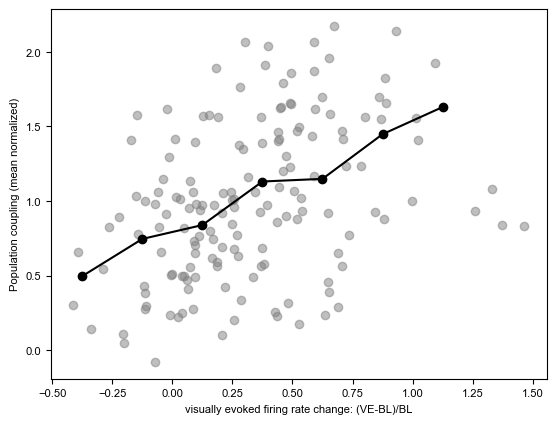

Time since last sync = 207.35 s


In [199]:
# pop_couplings_shuffle = np.nanmean(c_is_shuffle, axis = -1)
pop_couplings_shuffle = np.nanmean(c_is_shuffle_lp, axis = -1)
pop_couplings_shuffle = pop_couplings_shuffle/np.mean(pop_couplings_shuffle)

fr_increase_shuffle = np.mean(roi_spike_rates[roi_idxs_shuffle,:,1,:], axis = (-1,-2))/np.mean(roi_spike_rates[roi_idxs_shuffle,:,0,:], axis = (-1,-2))
fr_increase_shuffle = fr_increase_shuffle - 1

plot_xs = fr_increase_shuffle
plot_ys = pop_couplings_shuffle

bin_edges = np.arange(-0.5,1.5,0.25)
nof_bins = len(bin_edges) - 1
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_heights = np.zeros((nof_bins,))
for i_bin in range(nof_bins):
    cur_bin_mask = np.logical_and(plot_xs >= bin_edges[i_bin], plot_xs < bin_edges[i_bin+1])
    cur_bin_height = np.mean(plot_ys[cur_bin_mask])
    bin_heights[i_bin] = cur_bin_height

plt.figure()
plt.scatter(x = fr_increase, y = pop_couplings, color = "gray", alpha = 0.5)
plt.plot(bin_centers, bin_heights, '-ok')
plt.xlabel("visually evoked firing rate change: (VE-BL)/BL")
plt.ylabel("Population coupling (mean normalized)")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

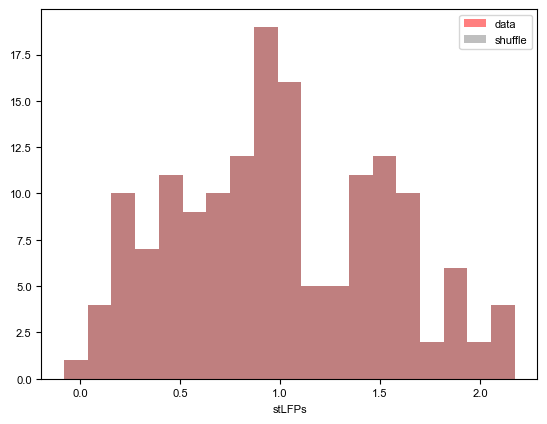

In [200]:
plot_vals = np.stack([pop_couplings, pop_couplings_shuffle], axis = 0)
plot_labels = ["data", "shuffle"]
plot_colors = ["red", "gray"]

plot_bin_edges = np.linspace(np.min(plot_vals), np.max(plot_vals), 20)

plt.figure()
for i_set in range(plot_vals.shape[0]):
    plt.hist(
        plot_vals[i_set,:], 
        bins = plot_bin_edges,
        alpha = 0.5, 
        color = plot_colors[i_set],
        label = plot_labels[i_set],
    )
plt.legend()
plt.xlabel("stLFPs")
plt.show()


In [201]:
dst_data_subdir_path = os.path.join(dst_dir_path, dst_data_subdir_name)

if not os.path.isdir(dst_data_subdir_path):
    os.makedirs(dst_data_subdir_path)

print(dst_data_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)  

M:\2023-05-11\M347\FOV02\Group01\spike_triggered_event_analysis\data
Time since last sync = 207.74 s


In [202]:
dst_data_file_name = "spike_triggered_event_analysis.hdf5"
dst_data_file_path = os.path.join(dst_data_subdir_path, dst_data_file_name)

with h5py.File(dst_data_file_path, "w") as hdf5_file:
    hdf5_file.create_dataset("src_hdf5_file_path", data = src_hdf5_file_path)
    hdf5_file.create_dataset("src_lfp_file_path", data = src_lfp_file_path)
    hdf5_file.create_dataset("time_per_frame_ms", data = time_per_frame_ms)
    hdf5_file.create_dataset("ms_to_s", data = ms_to_s)
    hdf5_file.create_dataset("s_to_ms", data = s_to_ms)
    hdf5_file.create_dataset("fs", data = fs)
    hdf5_file.create_dataset("nof_rois", data = nof_rois)
    hdf5_file.create_dataset("nof_trials", data = nof_trials)
    hdf5_file.create_dataset("nof_frames", data = nof_frames)
    hdf5_file.create_dataset("nof_orients", data = nof_orients)
    hdf5_file.create_dataset("stim_tstamp_s", data = stim_tstamp_s)
    hdf5_file.create_dataset("stim_tstamp", data = stim_tstamp)
    hdf5_file.create_dataset("t_test_pass_mask", data = t_test_pass_mask)
    hdf5_file.create_dataset("diff_t_test_pass_mask", data = diff_t_test_pass_mask)
    hdf5_file.create_dataset("gather_t_test_pass_mask", data = gather_t_test_pass_mask)
    hdf5_file.create_dataset("anova_test_pass_mask", data = anova_test_pass_mask)
    hdf5_file.create_dataset("diff_anova_test_pass_mask", data = diff_anova_test_pass_mask)
    hdf5_file.create_dataset("roi_spike_events", data = roi_spike_events)
    hdf5_file.create_dataset("roi_subthd_dFFs", data = roi_subthd_dFFs)
    hdf5_file.create_dataset("roi_spike_rates", data = roi_spike_rates)
    hdf5_file.create_dataset("lfp_dffs", data = lfp_dffs)
    hdf5_file.create_dataset("tot_population_rates", data = tot_population_rates)
    hdf5_file.create_dataset("tot_lpf_dffs", data = tot_lpf_dffs)
    hdf5_file.create_dataset("spike_win_lens", data = spike_win_lens)
    hdf5_file.create_dataset("roi_prs", data = roi_prs)
    hdf5_file.create_dataset("sta_prs", data = sta_prs)
    hdf5_file.create_dataset("sta_lfp_dffs", data = sta_lfp_dffs)
    hdf5_file.create_dataset("trial_avg_sta_prs", data = trial_avg_sta_prs)
    hdf5_file.create_dataset("trial_avg_sta_lfp_dffs", data = trial_avg_sta_lfp_dffs)
    hdf5_file.create_dataset("trial_avg_sta_prs_lp", data = trial_avg_sta_prs_lp)
    hdf5_file.create_dataset("sta_pr_amps", data = sta_pr_amps)
    hdf5_file.create_dataset("sta_pr_lp_amps", data = sta_pr_lp_amps)
    hdf5_file.create_dataset("sta_lfp_amps", data = sta_lfp_amps)
    hdf5_file.create_dataset("f_i_norms", data = f_i_norms)
    hdf5_file.create_dataset("c_is", data = c_is)
    hdf5_file.create_dataset("roi_spike_events_lp", data = roi_spike_events_lp)
    hdf5_file.create_dataset("c_is_lp", data = c_is_lp)
    hdf5_file.create_dataset("pop_couplings", data = pop_couplings)
    hdf5_file.create_dataset("fr_increase", data = fr_increase)
    hdf5_file.create_dataset("roi_idxs_shuffle", data = roi_idxs_shuffle)
    hdf5_file.create_dataset("trace_idxs_shuffle", data = trace_idxs_shuffle)
    hdf5_file.create_dataset("roi_spike_events_shuffle", data = roi_spike_events_shuffle)
    hdf5_file.create_dataset("lfp_dffs_shuffle", data = lfp_dffs_shuffle)
    hdf5_file.create_dataset("roi_prs_shuffle", data = roi_prs_shuffle)
    hdf5_file.create_dataset("sta_prs_shuffle", data = sta_prs_shuffle)
    hdf5_file.create_dataset("sta_lfp_dffs_shuffle", data = sta_lfp_dffs_shuffle)
    hdf5_file.create_dataset("trial_avg_sta_prs_shuffle", data = trial_avg_sta_prs_shuffle)
    hdf5_file.create_dataset("trial_avg_sta_lfp_dffs_shuffle", data = trial_avg_sta_lfp_dffs_shuffle)
    hdf5_file.create_dataset("trial_avg_sta_prs_shuffle_lp", data = trial_avg_sta_prs_shuffle_lp)
    hdf5_file.create_dataset("sta_pr_amps_shuffle", data = sta_pr_amps_shuffle)
    hdf5_file.create_dataset("sta_pr_lp_amps_shuffle", data = sta_pr_lp_amps_shuffle)
    hdf5_file.create_dataset("sta_lfp_amps_shuffle", data = sta_lfp_amps_shuffle)
    hdf5_file.create_dataset("f_i_norms_shuffle", data = f_i_norms_shuffle)
    hdf5_file.create_dataset("c_is_shuffle", data = c_is_shuffle)
    hdf5_file.create_dataset("roi_spike_events_shuffle_lp", data = roi_spike_events_shuffle_lp)
    hdf5_file.create_dataset("c_is_shuffle_lp", data = c_is_shuffle_lp)
    hdf5_file.create_dataset("pop_couplings_shuffle", data = pop_couplings_shuffle)
    hdf5_file.create_dataset("fr_increase_shuffle", data = fr_increase_shuffle)

print("result data file saved to: " + dst_data_file_path)

dst_notebook_file_name = "spike_triggered_event_analysis.ipynb"
dst_notebook_file_path = os.path.join(dst_data_subdir_path, dst_notebook_file_name)
%notebook $dst_notebook_file_path

SAVE_PROGRESS(HISTORY_FILEPATH)  

result data file saved to: M:\2023-05-11\M347\FOV02\Group01\spike_triggered_event_analysis\data\spike_triggered_event_analysis.hdf5
Time since last sync = 210.75 s
